# Input Data

In [1]:
import pandas as pd
import torch
import numpy as np
import networkx as nx
import scipy.sparse as sp
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_undirected, from_scipy_sparse_matrix,dense_to_sparse,is_undirected
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn import GCNConv
from torch_geometric.utils import softmax
import torch.nn as nn
from torch.nn import Linear, Parameter,Embedding
import torch.nn.functional as F
from torch_scatter import scatter_mean, scatter, scatter_add, scatter_max
from tqdm import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score

C:\Users\caleb\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "hw2_data/"
dss = ['dataset1','dataset2','dataset3'] #datasets
dataset = dict()
for ds in dss:
    dataset[ds] = dict()
    dataset[ds]['content'] = pd.read_csv(path+ds+"/content.csv",delimiter = '\t',header = None)
    dataset[ds]['train'] = pd.read_csv(path+ds+"/train.csv",delimiter = ',')
    dataset[ds]['test'] = pd.read_csv(path+ds+"/test.csv",delimiter = ',')
    dataset[ds]['upload'] = pd.read_csv(path+ds+"/upload.csv",delimiter = ',')
dataset[dss[2]]['test'].head()

,id,to,from
0,E370,26,317
1,E667,196,323
2,E3190,739,468
3,E848,576,156
4,E2161,466,199


## Data Explore

In [3]:
print(dataset[dss[0]]['content'].shape)
print(len(dataset[dss[0]]['content']))
np.array(dataset[dss[0]]['content'].iloc[0,1:]).shape

(2708, 1434)
2708


(1433,)

In [4]:
print(dataset[dss[0]]['train'].shape)
print(len(dataset[dss[0]]['train']))
dataset[dss[0]]['train'].loc[1,'to']

(8686, 4)
8686


2397

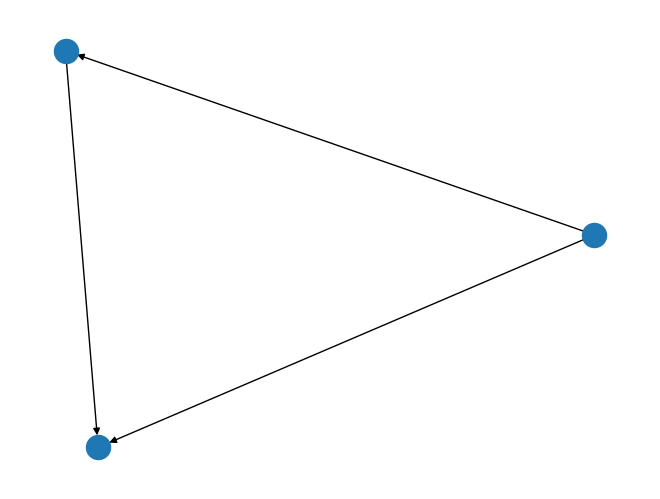

In [5]:
G = nx.DiGraph()
G.add_edge(0,1,label=0)
G.add_edge(0,2,label=1)
G.add_edge(1,2,label=1)
nx.draw(G)

In [6]:
[e for e in list(G.edges.data('label')) if e[2]==1]

[(0, 2, 1), (1, 2, 1)]

In [7]:
#For example:
Content = dataset[dss[0]]['content']
Train = dataset[dss[0]]['train']
Test = dataset[dss[0]]['test']
Upload = dataset[dss[0]]['upload']

In [8]:
Content.shape

(2708, 1434)

In [9]:
Train[Train['from']==4]

,id,to,from,label
14,E10087,1767,4,1
1698,E2206,2062,4,1
5178,E783,455,4,0
5845,E1142,1547,4,1


---
# Main

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda


In [11]:
def set_random_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

## Data Preprocessing

In [12]:
def floor(x):
    return torch.div(x, 1, rounding_mode='trunc')

In [13]:
def preprocess_features(features):
    # Row-normalize feature matrix and convert to tuple representation
    # Because the datasets only have binary features, row-normalize is unnecessary
    rowsum = np.array(features.sum(1),dtype = np.float32)
    rowsum = (rowsum==0)*1+rowsum
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

In [14]:
def load_data(content,train, test):
    G = nx.DiGraph()
    # for easier split the edges, create 2 graph, 1 with positive edge, the other with given negative edges
    G_pos = nx.DiGraph()
    G_neg = nx.DiGraph()
    graph_node_features_dict = dict()
    
    for i in range(len(content)):
        #graph_node_features_dict[content.iloc[i,0]] = np.array(content.iloc[i,1:])
        G.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        # pos and neg
        G_pos.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        G_neg.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        
    for i in range(len(train)):
        # Adding nodes into G
        '''
        if train.loc[i,'from'] not in G:
            G.add_node(train.loc[i,'from'],features = graph_node_features_dict[train.loc[i,'from']])
        if train.loc[i,'to'] not in G:
            G.add_node(train.loc[i,'to'],features = graph_node_features_dict[train.loc[i,'to']])
        ''' 
        # Adding edges
        G.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        
        # pos and neg
        if train.loc[i,'label'] == 0: 
            G_neg.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        else:
            G_pos.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])

    adj = nx.adjacency_matrix(G,sorted(G.nodes()))
    adj_pos = nx.adjacency_matrix(G_pos,sorted(G_pos.nodes()))
    adj_neg = nx.adjacency_matrix(G_neg,sorted(G_neg.nodes()))
    features = np.array(
        [features for _, features in sorted(G.nodes(data='features'), key=lambda x: x[0])])
    
    # Skip train,valid,and test mask
    
    num_features = features.shape[1]
    features = torch.FloatTensor(features)
    return adj, adj_pos, adj_neg, features, num_features

In [15]:
g, pos, neg, features, num_features = load_data(Content,Train,Test)

In [16]:
def split_edges(data):
    set_random_seed(10) #Seed is randomly set
    
    # ? This select the edges that from<to, but why? Don't understand, not using this
    row, col = data.edge_index
    mask = row < col
    row, col = row[mask], col[mask]
    
    val_ratio = 0.1
    #test_ratio = 0.1
    
    #split positive edges
    row_pos, col_pos = data.pos
    mask_pos = row_pos < col_pos
    row_pos, col_pos = row_pos[mask_pos], col_pos[mask_pos]

    n_v = floor(val_ratio * row_pos.size(0)).int() #number of validation positive edges
    #n_t = floor(test_ratio * row_pos.size(0)).int() #number of test positive edges
    
    perm = torch.randperm(row_pos.size(0))
    row_pos, col_pos = row_pos[perm], col_pos[perm]
    r, c = row_pos[:n_v], col_pos[:n_v]
    data.val_pos = torch.stack([r, c], dim=0)
    #r, c = row_pos[n_v:n_v+n_t], col_pos[n_v:n_v+n_t]
    #data.test_pos = torch.stack([r, c], dim=0)
    #r, c = row_pos[n_v+n_t:], col_pos[n_v+n_t:]
    r, c = row_pos[n_v:], col_pos[n_v:]
    data.train_pos = torch.stack([r, c], dim=0)
    print("Positive edges shape(train,val):",end="")
    #print(data.train_pos.shape,data.test_pos.shape,data.val_pos.shape)
    print(data.train_pos.shape,data.val_pos.shape)
    
    #split neg edges
    row_neg, col_neg = data.neg
    mask_neg = row_neg < col_neg
    row_neg, col_neg = row_neg[mask_neg], col_neg[mask_neg]
    
    
    n_v = floor(val_ratio * row_neg.size(0)).int() #number of validation positive edges
    #n_t = floor(test_ratio * row_neg.size(0)).int() #number of test positive edges
    
    perm = torch.randperm(row_neg.size(0))
    row_neg, col_neg = row_neg[perm], col_neg[perm]
    r, c = row_neg[:n_v], col_neg[:n_v]
    data.val_neg = torch.stack([r, c], dim=0)
    #r, c = row_neg[n_v:n_v+n_t], col_neg[n_v:n_v+n_t]
    #data.test_neg = torch.stack([r, c], dim=0)
    #r, c = row_neg[n_v+n_t:], col_neg[n_v+n_t:]
    r, c = row_neg[n_v:], col_neg[n_v:]
    data.train_neg = torch.stack([r, c], dim=0)
    print("Negative edges shape(train,val):",end="")
    #print(data.train_neg.shape,data.test_neg.shape,data.val_neg.shape)
    print(data.train_neg.shape,data.val_neg.shape)

    #costruct real test edges
    row_test,col_test = data.test
    data.test = torch.stack([row_test,col_test],dim = 0)
    return data

In [17]:
def set_init_attribute_representation(data):
    # Construct data_observed and compute its node attributes & representation
    # Why create undirected edge? Don't use this
    # Now pretend args.observe_val_and_injection = False
    #print('Here')
    #print(data.train_pos.shape,data.train_pos[[1,0],:].shape)
    #print(data.train_pos,data.train_pos[[1,0],:])
    #print(data.train_pos[:,:],,data.train_pos[[1,0],:])
    edge_index = torch.cat((data.train_pos,data.train_pos[[1,0],:]),dim=1)
    #print(edge_index)
    #edge_index = data.train_pos
    #edge_index=torch.cat((edge_index,data.val_pos,data.val_pos[[1,0],:]),dim=1)
    data_observed = Data(edge_index=edge_index)
    data_observed.num_nodes = data.num_nodes
    #use the injection trick and add val data in observed graph 
    #edge_index_observed = torch.cat((data_observed.edge_index,\
    #    data.train_neg,data.train_neg[[1,0],:],data.val_neg,data.val_neg[[1,0],:]),dim=1)
    edge_index_observed = data_observed.edge_index
  
    #generate the initial node attribute if there isn't any
    init_attribute = 'n2v' # Can choose between 'n2v','one_hot','spc','ones','zeros',
    # But we already prepare features so it doesn't matter
    if data.x == None:
        if init_attribute =='n2v':
            from node2vec import CalN2V
            x = CalN2V(edge_index_observed)#,args)
        if init_attribute =='one_hot':
            x = F.one_hot(torch.arange(data.num_nodes), num_classes=data.num_nodes)
            x = x.float()
        if init_attribute =='spc':
            from SPC import spc
            x = spc(edge_index_observed)#,args)
            x = x.float()
        if init_attribute =='ones':
            embedding_dim = 32
            x = torch.ones(data.num_nodes,args.embedding_dim)
            x = x.float()
        if init_attribute =='zeros':
            embedding_dim = 32
            x = torch.zeros(data.num_nodes,args.embedding_dim)
            x = x.float()
    else:
        x = data.x
    #generate the initial node representation using unsupervised models
    
    init_representation = None # Don't understand what this part doing
    if init_representation != None:
        val_and_test=[data.test_pos,data.test_neg,data.val_pos,data.val_neg]
        num_nodes,_=x.shape
        #add self-loop for the last node to aviod losing node if the last node dosen't have a link.
        if (num_nodes-1) in edge_index_observed:
            edge_index_observed=edge_index_observed.clone().detach()
        else:
            edge_index_observed=torch.cat((edge_index_observed.clone().detach(),torch.tensor([[num_nodes-1],[num_nodes-1]])),dim=1)
        if init_representation == 'gic':
            par_dir = os.path.abspath(os.path.join(os.path.dirname(__file__),".."))
            sys.path.append('%s/software/GIC/' % args.par_dir)
            from GICEmbs import CalGIC
            data_observed.x, auc, ap = CalGIC(edge_index_observed, x, args.data_name, val_and_test,args)

        if init_representation == 'vgae':
            from vgae import CalVGAE
            data_observed.x, auc, ap = CalVGAE(edge_index_observed, x, val_and_test, args)
        if init_representation == 'svgae':
            from svgae import CalSVGAE
            data_observed.x, auc, ap = CalSVGAE(edge_index_observed, x, val_and_test, args)
        if init_representation == 'argva':
            from argva import CalARGVA
            data_observed.x, auc, ap = CalARGVA(edge_index_observed, x, val_and_test, args)
        feature_results=[auc,ap]
    else:
        data_observed.x = x
        feature_results=None

    return data_observed,feature_results

In [18]:
def k_hop_subgraph(node_idx, num_hops, edge_index, max_nodes_per_hop = None,num_nodes = None):
  
    if num_nodes == None:
        num_nodes = torch.max(edge_index)+1
    row, col = edge_index
    node_mask = row.new_empty(num_nodes, dtype=torch.bool)
    edge_mask = row.new_empty(row.size(0), dtype=torch.bool)

    node_idx = node_idx.to(row.device)

    subsets = [node_idx]

    if max_nodes_per_hop == None:
        for _ in range(num_hops):
            node_mask.fill_(False)
            node_mask[subsets[-1]] = True
            torch.index_select(node_mask, 0, row, out = edge_mask)
            subsets.append(col[edge_mask])
    else:
        not_visited = row.new_empty(num_nodes, dtype=torch.bool)
        not_visited.fill_(True)
        for _ in range(num_hops):
            node_mask.fill_(False)# the source node mask in this hop
            node_mask[subsets[-1]] = True #mark the sources
            not_visited[subsets[-1]] = False # mark visited nodes
            torch.index_select(node_mask, 0, row, out = edge_mask) # indices of all neighbors
            neighbors = col[edge_mask].unique() #remove repeats
            neighbor_mask = row.new_empty(num_nodes, dtype=torch.bool) # mask of all neighbor nodes
            edge_mask_hop = row.new_empty(row.size(0), dtype=torch.bool) # selected neighbor mask in this hop
            neighbor_mask.fill_(False)
            neighbor_mask[neighbors] = True
            neighbor_mask = torch.logical_and(neighbor_mask, not_visited) # all neighbors that are not visited
            ind = torch.where(neighbor_mask==True) #indicies of all the unvisited neighbors
            if ind[0].size(0) > max_nodes_per_hop:
                perm = torch.randperm(ind[0].size(0))
                ind = ind[0][perm]
                neighbor_mask[ind[max_nodes_per_hop:]] = False # randomly select max_nodes_per_hop nodes
                torch.index_select(neighbor_mask, 0, col, out = edge_mask_hop)# find the indicies of selected nodes
                edge_mask = torch.logical_and(edge_mask,edge_mask_hop) # change edge_mask
            subsets.append(col[edge_mask])

    subset, inv = torch.cat(subsets).unique(return_inverse=True)
    inv = inv[:node_idx.numel()]

    node_mask.fill_(False)
    node_mask[subset] = True
    edge_mask = node_mask[row] & node_mask[col]

    edge_index = edge_index[:, edge_mask]

    node_idx = row.new_full((num_nodes, ), -1)
    node_idx[subset] = torch.arange(subset.size(0), device=row.device)
    edge_index = node_idx[edge_index]

    return subset, edge_index, inv, edge_mask

In [19]:
def plus_edge(data_observed, label, p_edge):
    num_hops = 4 # number of hops in sampling subgraph, set 2 which same as default
    max_nodes_per_hop =  None #when the graph is too large or too dense, 
    #we need max node per hop threshold to avoid OOM. Default is None
    nodes, edge_index_m, mapping, _ = k_hop_subgraph(node_idx= p_edge, num_hops= num_hops,\
 edge_index = data_observed.edge_index, max_nodes_per_hop= max_nodes_per_hop ,num_nodes=data_observed.num_nodes)
    x_sub = data_observed.x[nodes,:]
    edge_index_p = edge_index_m
    edge_index_p = torch.cat((edge_index_p, mapping.view(-1,1)),dim=1)
    edge_index_p = torch.cat((edge_index_p, mapping[[1,0]].view(-1,1)),dim=1)

    #edge_mask marks the edge under perturbation, i.e., the candidate edge for LP
    edge_mask = torch.ones(edge_index_p.size(1),dtype=torch.bool)
    edge_mask[-1] = False
    edge_mask[-2] = False
    
    '''
    # Run here for drnl labeling
    if drnl == True:
        num_nodes = torch.max(edge_index_p)+1
        z = drnl_node_labeling(edge_index_m, mapping[0],mapping[1],num_nodes)
        data = Data(edge_index = edge_index_p, x = x_sub, z = z)
    '''
    data = Data(edge_index = edge_index_p, x = x_sub, z = 0)
    data.edge_mask = edge_mask

    #label = 1 if the candidate link (p_edge) is positive and label=0 otherwise
    data.label = float(label)

    return data

In [20]:
def minus_edge(data_observed, label, p_edge):
    num_hops = 2 # number of hops in sampling subgraph, set 2 which same as default
    max_nodes_per_hop =  None #when the graph is too large or too dense, 
    #we need max node per hop threshold to avoid OOM. Default is None
    
    nodes, edge_index_p, mapping,_ = k_hop_subgraph(node_idx= p_edge, num_hops=num_hops,\
 edge_index = data_observed.edge_index,max_nodes_per_hop=max_nodes_per_hop, num_nodes = data_observed.num_nodes)
    x_sub = data_observed.x[nodes,:]

    #edge_mask marks the edge under perturbation, i.e., the candidate edge for LP
    edge_mask = torch.ones(edge_index_p.size(1), dtype = torch.bool)
    ind = torch.where((edge_index_p == mapping.view(-1,1)).all(dim=0))
    edge_mask[ind[0]] = False
    ind = torch.where((edge_index_p == mapping[[1,0]].view(-1,1)).all(dim=0))
    edge_mask[ind[0]] = False
    '''
    if args.drnl == True:
        num_nodes = torch.max(edge_index_p)+1
        z = drnl_node_labeling(edge_index_p[:,edge_mask], mapping[0],mapping[1],num_nodes)
        data = Data(edge_index = edge_index_p, x= x_sub,z = z)
    else:
    '''
    data = Data(edge_index = edge_index_p, x= x_sub,z = 0)
    data.edge_mask = edge_mask

    #label = 1 if the candidate link (p_edge) is positive and label=0 otherwise
    data.label = float(label)
    return data

In [21]:
# Prepare the data
def prepare_data(content,train,test):
    g, pos, neg, features, num_features = load_data(content,train,test)
    A = g.toarray()
    edge_index,_ = dense_to_sparse(torch.tensor(A))
    Apos = pos.toarray()
    edge_index_pos,_ = dense_to_sparse(torch.tensor(Apos))
    Aneg = neg.toarray()
    edge_index_neg,_ = dense_to_sparse(torch.tensor(Aneg))
    data = Data(edge_index=edge_index,x=features.to(torch.float),
                pos = edge_index_pos,neg = edge_index_neg,test = torch.tensor([Test['from'],Test['to']]))
    data = split_edges(data)
    

    set_random_seed(42) # Random set the seed
    data_observed,feature_results= set_init_attribute_representation(data)
    # Construct train, val and test data loader
    set_random_seed(42)
    train_graphs = []
    val_graphs = []
    test_graphs = []
    for i in range(data.train_pos.size(1)):
        train_graphs.append(minus_edge(data_observed,1,data.train_pos[:,i]))

    for i in range(data.train_neg.size(1)):
        train_graphs.append(plus_edge(data_observed,0,data.train_neg[:,i]))
    '''
    for i in range(data.test_pos.size(1)):
        test_graphs.append(plus_edge(data_observed,1,data.test_pos[:,i]))

    for i in range(data.test_neg.size(1)):
        test_graphs.append(plus_edge(data_observed,0,data.test_neg[:,i]))   
    '''
    for i in range(data.test.size(1)):
        test_graphs.append(plus_edge(data_observed,1,data.test[:,i]))
    
    #if args.observe_val_and_injection == False:
    # pretend args.observe_val_and_injection == False
    for i in range(data.val_pos.size(1)):
        val_graphs.append(plus_edge(data_observed,1,data.val_pos[:,i]))

    for i in range(data.val_neg.size(1)):
        val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i]))
    '''
    else:
        for i in range(data.val_pos.size(1)):
            val_graphs.append(minus_edge(data_observed,1,data.val_pos[:,i]))

        for i in range(data.val_neg.size(1)):
            val_graphs.append(plus_edge(data_observed,0,data.val_neg[:,i]))
    '''

    
    print('Train_link:', str(len(train_graphs)),
          ' Val_link:',str(len(val_graphs)),' Test_link:',str(len(test_graphs)))

    batch_size = 32
    train_loader = DataLoader(train_graphs,batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_graphs,batch_size=batch_size,shuffle=True)
    test_loader = DataLoader(test_graphs,batch_size=batch_size,shuffle=False)

    return train_loader, val_loader, test_loader,feature_results

In [22]:
train_loader, val_loader, test_loader,feature_results = prepare_data(Content,Train,Test)
test_loader

Positive edges shape(train,val):torch.Size([2, 1945]) torch.Size([2, 216])
Negative edges shape(train,val):torch.Size([2, 1882]) torch.Size([2, 209])
Train_link: 3827  Val_link: 425  Test_link: 2172


In [23]:
torch.cuda.empty_cache()

In [24]:
num_features = next(iter(train_loader)).x.size(1)
num_features

1433

In [25]:
print("Dimention of features after concatenation:",num_features)
set_random_seed(42)

Dimention of features after concatenation: 1433


# Model

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [27]:
class LinkPred(MessagePassing):
    def __init__(self, in_channels: int, hidden_channels: int, heads: int = 1,\
                 walk_len: int = 6, drnl: bool = False, z_max: int =100, MSE: bool=True):
        super(LinkPred, self).__init__()

        self.drnl = drnl
        if drnl == True:
            self.z_embedding = Embedding(z_max, hidden_channels)

        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)

        self.wp = WalkPooling(in_channels + hidden_channels*2,\
            hidden_channels, heads, walk_len)

        L=walk_len*5+1
        self.classifier = MLP(L*heads,MSE=MSE)
        self.norm = nn.BatchNorm1d(hidden_channels)

    def forward(self, x, edge_index, edge_mask, batch, z = None):
        
        #using drnl
        if self.drnl == True:
            z_emb = self.z_embedding(z)
            if z_emb.ndim == 3:  # in case z has multiple integer labels
                z_emb = z_emb.sum(dim=1)
            z_emb = z_emb.view(x.size(0),-1)
            x = torch.cat((x,z_emb.view(x.size(0),-1)),dim=1)
        
        #GCN layers
        x_out = x
        x = self.conv1(x, edge_index)
        x_out = torch.cat((x_out,x),dim=1)
        x = x.relu()
        x = self.norm(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.norm(x)
        x_out = torch.cat((x_out,x),dim=1)

        #Walk Pooling
        feature_list = self.wp(x_out, edge_index, edge_mask, batch)

        #Classifier
        out = self.classifier(feature_list)

        return out


class WalkPooling(MessagePassing):
    def __init__(self, in_channels: int, hidden_channels: int, heads: int = 1,\
                 walk_len: int = 6):
        super(WalkPooling, self).__init__()

        self.hidden_channels = hidden_channels
        self.heads = heads
        self.walk_len = walk_len

        # the linear layers in the attention encoder
        self.lin_key1 = Linear(in_channels, hidden_channels)
        self.lin_query1 = Linear(in_channels, hidden_channels)
        self.lin_key2 = Linear(hidden_channels, heads * hidden_channels)
        self.lin_query2 = Linear(hidden_channels, heads * hidden_channels)
    def attention_mlp(self, x, edge_index):
    
        query = self.lin_key1(x).reshape(-1,self.hidden_channels)
        key = self.lin_query1(x).reshape(-1,self.hidden_channels)

        query = F.leaky_relu(query,0.2)
        key = F.leaky_relu(key,0.2)

        query = F.dropout(query, p=0.5, training=self.training)
        key = F.dropout(key, p=0.5, training=self.training)

        query = self.lin_key2(query).view(-1, self.heads, self.hidden_channels)
        key = self.lin_query2(key).view(-1, self.heads, self.hidden_channels)

        row, col = edge_index
        weights = (query[row] * key[col]).sum(dim=-1) / np.sqrt(self.hidden_channels)
        
        return weights

    def weight_encoder(self, x, edge_index, edge_mask):        
     
        weights = self.attention_mlp(x, edge_index)
    
        omega = torch.sigmoid(weights[torch.logical_not(edge_mask)])
        
        row, col = edge_index
        num_nodes = torch.max(edge_index)+1

        # edge weights of the plus graph
        weights_p = softmax(weights,edge_index[1])

        # edge weights of the minus graph
        weights_m = weights - scatter_max(weights, col, dim=0, dim_size=num_nodes)[0][col]
        weights_m = torch.exp(weights_m)
        weights_m = weights_m * edge_mask.view(-1,1)
        norm = scatter_add(weights_m, col, dim=0, dim_size=num_nodes)[col] + 1e-16
        weights_m = weights_m / norm

        return weights_p, weights_m, omega

    def forward(self, x, edge_index, edge_mask, batch):
        
        #encode the node representation into edge weights via attention mechanism
        weights_p, weights_m, omega = self.weight_encoder(x, edge_index, edge_mask)

        # pytorch geometric set the batch adjacency matrix to
        # be the diagonal matrix with each graph's adjacency matrix
        # stacked in the diagonal. Therefore, calculating the powers
        # of the stochastic matrix directly will cost lots of memory.
        # We compute the powers of stochastic matrix as follows
        # Let A = diag ([A_1,\cdots,A_n]) be the batch adjacency matrix,
        # we set x = [x_1,\cdots,x_n]^T be the batch feature matrix
        # for the i-th graph in the batch with n_i nodes, its feature 
        # is a n_i\times n_max matrix, where n_max is the largest number
        # of nodes for all graphs in the batch. The elements of x_i are
        # (x_i)_{x,y} = \delta_{x,y}. 

        # number of graphs in the batch
        batch_size = torch.max(batch)+1

        # for node i in the batched graph, index[i] is i's id in the graph before batch 
        index = torch.zeros(batch.size(0),1,dtype=torch.long)
        
        # numer of nodes in each graph
        _, counts = torch.unique(batch, sorted=True, return_counts=True)
        
        # maximum number of nodes for all graphs in the batch
        max_nodes = torch.max(counts)

        # set the values in index
        id_start = 0
        for i in range(batch_size):
            index[id_start:id_start+counts[i]] = torch.arange(0,counts[i],dtype=torch.long).view(-1,1)
            id_start = id_start+counts[i]

        index = index.to(device)
        
        #the output graph features of walk pooling
        nodelevel_p = torch.zeros(batch_size,(self.walk_len*self.heads)).to(device)
        nodelevel_m = torch.zeros(batch_size,(self.walk_len*self.heads)).to(device)
        linklevel_p = torch.zeros(batch_size,(self.walk_len*self.heads)).to(device)
        linklevel_m = torch.zeros(batch_size,(self.walk_len*self.heads)).to(device)
        graphlevel = torch.zeros(batch_size,(self.walk_len*self.heads)).to(device)
        # a link (i,j) has two directions i->j and j->i, and
        # when extract the features of the link, we usually average over
        # the two directions. indices_odd and indices_even records the
        # indices for a link in two directions
        indices_odd = torch.arange(0,omega.size(0),2).to(device)
        indices_even = torch.arange(1,omega.size(0),2).to(device)

        omega = torch.index_select(omega, 0 ,indices_even)\
        + torch.index_select(omega,0,indices_odd)
        
        #node id of the candidate (or perturbation) link
        link_ij, link_ji = edge_index[:,torch.logical_not(edge_mask)]
        node_i = link_ij[indices_odd]
        node_j = link_ij[indices_even]

        # compute the powers of stochastic matrix
        for head in range(self.heads):

            # x on the plus graph and minus graph
            x_p = torch.zeros(batch.size(0),max_nodes,dtype=x.dtype).to(device)
            x_p = x_p.scatter_(1,index,1)
            x_m = torch.zeros(batch.size(0),max_nodes,dtype=x.dtype).to(device)
            x_m = x_m.scatter_(1,index,1)

            # propagage once
            x_p = self.propagate(edge_index, x= x_p, norm = weights_p[:,head])
            x_m = self.propagate(edge_index, x= x_m, norm = weights_m[:,head])
        
            # start from tau = 2
            for i in range(self.walk_len):
                #print(f"self.walk_len:{i}")
                x_p = self.propagate(edge_index, x= x_p, norm = weights_p[:,head])
                x_m = self.propagate(edge_index, x= x_m, norm = weights_m[:,head])
                
                # returning probabilities around i + j
                nodelevel_p_w = x_p[node_i,index[node_i].view(-1)] + x_p[node_j,index[node_j].view(-1)]
                nodelevel_m_w = x_m[node_i,index[node_i].view(-1)] + x_m[node_j,index[node_j].view(-1)]
                nodelevel_p[:,head*self.walk_len+i] = nodelevel_p_w.view(-1)
                nodelevel_m[:,head*self.walk_len+i] = nodelevel_m_w.view(-1)
  
                # transition probabilities between i and j
                linklevel_p_w = x_p[node_i,index[node_j].view(-1)] + x_p[node_j,index[node_i].view(-1)]
                linklevel_m_w = x_m[node_i,index[node_j].view(-1)] + x_m[node_j,index[node_i].view(-1)]
                linklevel_p[:,head*self.walk_len+i] = linklevel_p_w.view(-1)
                linklevel_m[:,head*self.walk_len+i] = linklevel_m_w.view(-1)

                # graph average of returning probabilities
                diag_ele_p = torch.gather(x_p,1,index)
                diag_ele_m = torch.gather(x_m,1,index)

                graphlevel_p = scatter_add(diag_ele_p, batch, dim = 0)
                graphlevel_m = scatter_add(diag_ele_m, batch, dim = 0)

                graphlevel[:,head*self.walk_len+i] = (graphlevel_p-graphlevel_m).view(-1)
         
        feature_list = graphlevel 
        feature_list = torch.cat((feature_list,omega),dim=1)
        feature_list = torch.cat((feature_list,nodelevel_p),dim=1)
        feature_list = torch.cat((feature_list,nodelevel_m),dim=1)
        feature_list = torch.cat((feature_list,linklevel_p),dim=1)
        feature_list = torch.cat((feature_list,linklevel_m),dim=1)


        return feature_list

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j  

class MLP(torch.nn.Module):
    # adopt a MLP as classifier for graphs
    def __init__(self,input_size,MSE=True):
        super(MLP, self).__init__()
        self.nn = nn.BatchNorm1d(input_size)
        self.linear1 = torch.nn.Linear(input_size,input_size*20)
        self.linear2 = torch.nn.Linear(input_size*20,input_size*20)
        self.linear3 = torch.nn.Linear(input_size*20,input_size*10)
        self.linear4 = torch.nn.Linear(input_size*10,input_size)
        self.linear5 = torch.nn.Linear(input_size,1)
        self.act= nn.ReLU()
        self.MSE=MSE
        self.norm1 = nn.BatchNorm1d(input_size*20)
        self.norm2 = nn.BatchNorm1d(input_size*20)
        self.norm3 = nn.BatchNorm1d(input_size*10)
        self.norm4 = nn.BatchNorm1d(input_size)
    def forward(self, x):
        out= self.nn(x)
        out= self.linear1(out)
        out = self.act(out)
        out = self.norm1(out)
        out= self.linear2(out)
        out = self.act(out)
        out = self.norm2(out)
        out = self.linear3(out)
        out = self.act(out)
        out = self.norm3(out)
        out = self.linear4(out)
        out = self.act(out)
        out = self.norm4(out)
        out = F.dropout(out, p=0.5, training=self.training)
        out = self.linear5(out)
        #out = torch.sigmoid(out)
        if self.MSE:
            out = torch.sigmoid(out)
        return out

In [28]:
def train(loader,epoch):
    model.train()
    loss_epoch=0
    for data in tqdm(loader,desc="train"):  # Iterate in batches over the training dataset.
        data = data.to(device)
        label= data.label
        out = model(data.x, data.edge_index, data.edge_mask, data.batch, data.z)
        torch.cuda.empty_cache()
        loss = criterion(out.view(-1), label)  
        optimizer.zero_grad()
        loss.backward()  
        optimizer.step()
        loss_epoch=loss_epoch+loss.item()
    return loss_epoch/len(loader)

In [29]:
def test(loader,data_type='test'):
    model.eval()
    scores = torch.tensor([])
    labels = torch.tensor([])
    loss_total=0
    with torch.no_grad():
        for data in tqdm(loader,desc='test:'+data_type):  # Iterate in batches over the training/test dataset.
            data = data.to(device)
            out = model(data.x, data.edge_index, data.edge_mask, data.batch, data.z)
            loss = criterion(out.view(-1), data.label)
            out = out.cpu().clone().detach()
            scores = torch.cat((scores,out),dim = 0)
            labels = torch.cat((labels,data.label.view(-1,1).cpu().clone().detach()),dim = 0)
        scores = scores.cpu().clone().detach().numpy()
        labels = labels.cpu().clone().detach().numpy()
        loss_total=loss_total+loss.item()
        return roc_auc_score(labels, scores), average_precision_score(labels, scores),loss_total,scores

In [30]:
walk_len = 7
lr = 0.005
heads = 2
hidden_channels = 32
batch_size = 32
epochs = 50
z_max = 100

In [31]:
model = LinkPred(in_channels = num_features, hidden_channels = hidden_channels,\
    heads = heads, walk_len = walk_len, drnl = False,z_max = z_max, MSE= True).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr,weight_decay=0.005)
criterion = torch.nn.MSELoss(reduction='mean')
#criterion = torch.nn.BCEWithLogitsLoss()

In [32]:
Best_Val_fromloss=1e10
Final_Test_AUC_fromloss=0
Final_Test_AP_fromloss=0

Best_Val_fromAUC=0
Final_Test_AUC_fromAUC=0
Final_Test_AP_fromAUC=0

for epoch in range(0, epochs):
    loss_epoch = train(train_loader,epoch)
    val_auc, val_ap, val_loss,_ = test(val_loader,data_type='val')
    #test_auc,test_ap,_,_ = test(test_loader,data_type='test')
    if val_loss < Best_Val_fromloss:
        Best_Val_fromloss = val_loss
        #Final_Test_AUC_fromloss = test_auc
        #Final_Test_AP_fromloss = test_ap

    if val_auc > Best_Val_fromAUC:
        Best_Val_fromAUC = val_auc
        #Final_Test_AUC_fromAUC = test_auc
        #Final_Test_AP_fromAUC = test_ap
    print(f'Epoch: {epoch:03d}, Loss : {loss_epoch:.4f},\
     Val Loss : {val_loss:.4f}, Val AUC: {val_auc:.4f}')
    '''
    print(f'Epoch: {epoch:03d}, Loss : {loss_epoch:.4f},\
     Val Loss : {val_loss:.4f}, Val AUC: {val_auc:.4f},\
      Test AUC: {test_auc:.4f}, Picked AUC:{Final_Test_AUC_fromAUC:.4f}')
print(f'From loss: Final Test AUC: {Final_Test_AUC_fromloss:.4f}, Final Test AP: {Final_Test_AP_fromloss:.4f}')
print(f'From AUC: Final Test AUC: {Final_Test_AUC_fromAUC:.4f}, Final Test AP: {Final_Test_AP_fromAUC:.4f}')
'''

test:val: 100%|██████████| 14/14 [00:00<00:00, 19.36it/s]


Epoch: 000, Loss : 0.2175,     Val Loss : 0.2783, Val AUC: 0.6346


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.19it/s]


Epoch: 001, Loss : 0.2142,     Val Loss : 0.2177, Val AUC: 0.6993


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.86it/s]


Epoch: 002, Loss : 0.2112,     Val Loss : 0.2500, Val AUC: 0.6892


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.68it/s]


Epoch: 003, Loss : 0.2078,     Val Loss : 0.2537, Val AUC: 0.7430


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.19it/s]


Epoch: 004, Loss : 0.2042,     Val Loss : 0.2832, Val AUC: 0.6108


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.65it/s]


Epoch: 005, Loss : 0.2051,     Val Loss : 0.2623, Val AUC: 0.7396


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.04it/s]


Epoch: 006, Loss : 0.2038,     Val Loss : 0.1572, Val AUC: 0.7320


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.43it/s]


Epoch: 007, Loss : 0.2023,     Val Loss : 0.2519, Val AUC: 0.7320


test:val: 100%|██████████| 14/14 [00:00<00:00, 23.08it/s]


Epoch: 008, Loss : 0.2027,     Val Loss : 0.2269, Val AUC: 0.7643


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.93it/s]


Epoch: 009, Loss : 0.2042,     Val Loss : 0.3327, Val AUC: 0.7433


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.52it/s]


Epoch: 010, Loss : 0.1998,     Val Loss : 0.1875, Val AUC: 0.7421


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.02it/s]


Epoch: 011, Loss : 0.2026,     Val Loss : 0.1757, Val AUC: 0.7040


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.96it/s]


Epoch: 012, Loss : 0.2024,     Val Loss : 0.4940, Val AUC: 0.7364


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.75it/s]


Epoch: 013, Loss : 0.2021,     Val Loss : 0.2014, Val AUC: 0.7487


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.76it/s]


Epoch: 014, Loss : 0.2028,     Val Loss : 0.2236, Val AUC: 0.7498


test:val: 100%|██████████| 14/14 [00:00<00:00, 16.50it/s]


Epoch: 015, Loss : 0.1989,     Val Loss : 0.2018, Val AUC: 0.7157


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.34it/s]


Epoch: 016, Loss : 0.2021,     Val Loss : 0.1739, Val AUC: 0.7436


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.23it/s]


Epoch: 017, Loss : 0.2017,     Val Loss : 0.3522, Val AUC: 0.7451


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.40it/s]


Epoch: 018, Loss : 0.2016,     Val Loss : 0.1319, Val AUC: 0.7280


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.86it/s]


Epoch: 019, Loss : 0.1998,     Val Loss : 0.2991, Val AUC: 0.7218


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.91it/s]


Epoch: 020, Loss : 0.2017,     Val Loss : 0.3808, Val AUC: 0.7465


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.01it/s]


Epoch: 021, Loss : 0.2018,     Val Loss : 0.1984, Val AUC: 0.7455


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.15it/s]


Epoch: 022, Loss : 0.2009,     Val Loss : 0.3441, Val AUC: 0.7163


test:val: 100%|██████████| 14/14 [00:00<00:00, 22.14it/s]


Epoch: 023, Loss : 0.2030,     Val Loss : 0.1749, Val AUC: 0.7429


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.51it/s]


Epoch: 024, Loss : 0.2014,     Val Loss : 0.1612, Val AUC: 0.7409


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.81it/s]


Epoch: 025, Loss : 0.1977,     Val Loss : 0.1735, Val AUC: 0.7348


test:val: 100%|██████████| 14/14 [00:00<00:00, 17.85it/s]


Epoch: 026, Loss : 0.2031,     Val Loss : 0.7721, Val AUC: 0.7470


test:val: 100%|██████████| 14/14 [00:00<00:00, 17.72it/s]


Epoch: 027, Loss : 0.2007,     Val Loss : 0.1351, Val AUC: 0.7468


test:val: 100%|██████████| 14/14 [00:00<00:00, 16.09it/s]


Epoch: 028, Loss : 0.2020,     Val Loss : 0.1725, Val AUC: 0.7335


test:val: 100%|██████████| 14/14 [00:01<00:00, 12.10it/s]


Epoch: 029, Loss : 0.2031,     Val Loss : 0.3490, Val AUC: 0.7473


test:val: 100%|██████████| 14/14 [00:01<00:00, 11.99it/s]


Epoch: 030, Loss : 0.2009,     Val Loss : 0.2562, Val AUC: 0.7517


test:val: 100%|██████████| 14/14 [00:00<00:00, 17.03it/s]


Epoch: 031, Loss : 0.2033,     Val Loss : 0.2430, Val AUC: 0.7508


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.06it/s]


Epoch: 032, Loss : 0.2031,     Val Loss : 0.1669, Val AUC: 0.7547


test:val: 100%|██████████| 14/14 [00:00<00:00, 17.19it/s]


Epoch: 033, Loss : 0.2027,     Val Loss : 0.2061, Val AUC: 0.7379


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.13it/s]


Epoch: 034, Loss : 0.2034,     Val Loss : 0.1933, Val AUC: 0.7465


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.73it/s]


Epoch: 035, Loss : 0.2035,     Val Loss : 0.1283, Val AUC: 0.7450


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.67it/s]


Epoch: 036, Loss : 0.2012,     Val Loss : 0.0814, Val AUC: 0.7469


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.34it/s]


Epoch: 037, Loss : 0.2055,     Val Loss : 0.2173, Val AUC: 0.7513


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.32it/s]


Epoch: 038, Loss : 0.2012,     Val Loss : 0.2640, Val AUC: 0.7480


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.47it/s]


Epoch: 039, Loss : 0.2020,     Val Loss : 0.2128, Val AUC: 0.7424


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.46it/s]


Epoch: 040, Loss : 0.2043,     Val Loss : 0.3651, Val AUC: 0.7419


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.96it/s]


Epoch: 041, Loss : 0.2048,     Val Loss : 0.2438, Val AUC: 0.7192


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.21it/s]


Epoch: 042, Loss : 0.2042,     Val Loss : 0.1857, Val AUC: 0.7478


test:val: 100%|██████████| 14/14 [00:00<00:00, 21.05it/s]


Epoch: 043, Loss : 0.2020,     Val Loss : 0.3409, Val AUC: 0.7478


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.25it/s]


Epoch: 044, Loss : 0.2046,     Val Loss : 0.2413, Val AUC: 0.7522


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.74it/s]


Epoch: 045, Loss : 0.2053,     Val Loss : 0.1237, Val AUC: 0.7226


test:val: 100%|██████████| 14/14 [00:00<00:00, 18.34it/s]


Epoch: 046, Loss : 0.2029,     Val Loss : 0.1861, Val AUC: 0.7396


test:val: 100%|██████████| 14/14 [00:00<00:00, 19.25it/s]


Epoch: 047, Loss : 0.2041,     Val Loss : 0.1703, Val AUC: 0.7516


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.82it/s]


Epoch: 048, Loss : 0.2052,     Val Loss : 0.1430, Val AUC: 0.7425


test:val: 100%|██████████| 14/14 [00:00<00:00, 20.55it/s]

Epoch: 049, Loss : 0.2057,     Val Loss : 0.1669, Val AUC: 0.7480


In [33]:
model.eval()
scores = torch.tensor([])
labels = torch.tensor([])
loss_total=0
with torch.no_grad():
    for data in tqdm(test_loader,desc='test:'):  # Iterate in batches over the training/test dataset.
        data = data.to(device)
        out = model(data.x, data.edge_index, data.edge_mask, data.batch, data.z)
        out = out.cpu().clone().detach()
        scores = torch.cat((scores,out),dim = 0)
    scores = scores.cpu().clone().detach().numpy()
scores.shape

test:: 100%|██████████| 68/68 [00:03<00:00, 17.49it/s]


(2172, 1)

In [34]:
scores.flatten()

array([0.37016982, 0.4772248 , 0.4741943 , ..., 0.37016976, 0.37016982,
       0.6684545 ], dtype=float32)

In [35]:
Upload['prob'] = scores.flatten().astype('float64')
Upload

,id,prob
0,E10559,0.370170
1,E4849,0.477225
2,E3964,0.474194
3,E542,0.498574
4,E331,0.434714
...,...,...
2167,E2524,0.370170
2168,E4324,0.370170
2169,E1384,0.370170
2170,E7582,0.370170


In [36]:
Upload.to_csv('output/1.csv',index=False)